# Density Prediction

Notebook to use the Murphy et al. [2024] density model to generate predictions. 

[Model Fitting](./RF_model.ipynb) is done here and saved into a pickle file. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [ ]:
class rf_den():

    def __init__(self, input_f: str=None):

        self.feat_cols = ['1300_02','43000_09','85550_13','94400_18','SYM_H index','AE']
        self.input_f = input_f
        self.load_mod_feat()

    def load_mod_feat(self):

        if not self.input_f: 
            print('Must provide an input file.')
            print('Before continuing provodie an input file')
            print('self.input = path to file')
            print('self.load_mod_feat()')
        else:
            mdl_dat = pd.read_pickle(self.input_f) 
            self.feat = mdl_dat[-2].copy().reset_index(drop=True)
            self.rfmod = mdl_dat[0]
            del mdl_dat

    def setup_grid(self):

        self.radii = np.linspace(0.999,0.001,self.n_lat) # start at 0.01 to avoid pole singularity
        self.satLat_N = np.arccos(self.radii)*180/np.pi
        self.satLat_S = -self.satLat_N

        self.mlt = np.linspace(0,24,self.n_mlt, endpoint=False) # don't include endpoint to avoid overlap
        self.theta = self.mlt*2*np.pi/24

        # setup two dimensional grid
        self.radMesh, self.thtMesh = np.meshgrid(self.radii, self.theta, indexing='ij')
        self.satlt_mesh_N, self.MLT_mesh = np.meshgrid(self.satLat_N, self.mlt, indexing='ij')
        self.satlt_mesh_S = -self.satlt_mesh_N

        # and flatten for use in appending to feature data
        self.satLat_N = self.satlt_mesh_N.flatten()
        self.satLat_S = self.satlt_mesh_S.flatten()
        self.satMLT = self.MLT_mesh.flatten()
        self.cos_theta = np.cos(self.thtMesh.flatten())
        self.sin_theta = np.sin(self.thtMesh.flatten())
    
    def make_grid(self, event, north: bool):
        if isinstance(event, pd.Series):
            # need to convert to dataFrame for grid generation
            evt = event.to_frame().transpose()
        else:
            evt = event

        grid = pd.DataFrame()
        for _, row in evt.iterrows():
            gs = pd.concat([row.to_frame().transpose()]*self.n_lat*self.n_mlt,ignore_index=True)

            gs['SatLat'] = self.satLat_N if north else self.satLat_S
            gs['cos_SatMagLT'] = self.cos_theta
            gs['sin_SatMagLT'] = self.sin_theta

            if grid.empty:
                grid = gs
            else:
                grid = pd.concat([grid,gs],ignore_index=True)
        
        return grid

    def pred_den2d(self, sdate: str='2003-01-01 00:00:00', edate: str=None, hemisphere: str='North',
                   n_lat: int=30, n_mlt: int=24):
        
        self.n_lat = n_lat
        self.n_mlt = n_mlt
        self.setup_grid()
        
        if edate:
            ev_id = (self.feat['DateTime'] >= sdate) & (self.feat['DateTime'] <= edate)
            event = self.feat.loc[ev_id, self.feat_cols+['DateTime']].copy()
        else:
            ev_id = self.feat.set_index('DateTime').index.get_loc(sdate) 
            event = self.feat.loc[ev_id, self.feat_cols+['DateTime']].copy().to_frame().transpose()
        
        north = True if hemisphere.upper() == 'NORTH' else False

        grid = self.make_grid(event,north=north)

        self.north = north
        
        grid['400 km den'] = self.rfmod.predict(grid.drop(columns='DateTime'))*(10**-12)
        
        self.den = grid[['DateTime','400 km den']]

        return grid
    
    def pred_denorb(self):
        pass
    
    def plot_dpolar(self, den, ax=None, fig=None, date=None, theta_offset: float =-0.5*np.pi, **kwargs):

        # check if an axis and figure are passed
        # if not grab the current ones
        if ax is None:
            # get current axis if none is passed
            ax = plt.gca()
        if fig is None:
            fig = plt.gcf()

        if date:
            den_p = den[den['DateTime'] == date,'400 km den'].to_numpy()
        else:
            den_p = den['400 km den'].to_numpy()[0:self.n_lat*self.n_mlt]

        # check if the current axis is polar
        # if not change it to polar by deleting
        # it and adding another
        if ax.name != 'polar':
            rows, cols, start, _ = ax.get_subplotspec().get_geometry()
            ax.remove()
            ax = fig.add_subplot(rows, cols, start+1, projection='polar')
        
        im = ax.pcolormesh(self.thtMesh, self.satlt_mesh_N, 
                           den_p.reshape(self.n_lat,self.n_mlt),
                           **kwargs)

        if self.north:
            ax.set_rlim(bottom=90, top=0)
        else:
            ax.set_rlim(bottom=-90, top=0)
        
        ax.set_theta_offset(theta_offset)
        fig.colorbar(im)

        return im

    def plot_dgeo():
        pass

    def plot_dorbit():
        pass




In [97]:
mdl_sv = r"D:\data\SatDensities\FI_GEO_RFdat_AIMFAHR.pkl"
a = rf_den(input_f=mdl_sv)
den = a.pred_den2d(sdate='2003-01-01 00:00', edate='2003-01-01 00:20')

hi


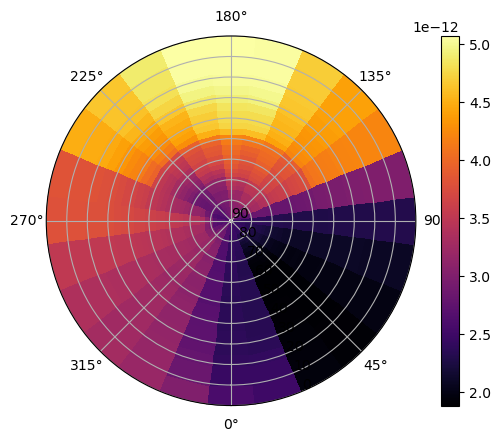

In [98]:
a.plot_dpolar(den,cmap=plt.cm.inferno)

# Types of Plots

There are three types of plots that we can generate. 

- Spatial Plots, density at a gridded lat and lon at fixed time
- Orbit Plots, density along an orbit as time varies
- Combination of the two (see two-dimensional density vary with time).
    - For computational time it's probably easier to generate these separately then overplot them

# Spatial Plots

Generate a grid in geo graphic latitude and magnetic local time which is used as model input. 